In [1]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq scikit-learn==1.3.2 --progress-bar off
!pip install -qqq pandas==2.1.3 --progress-bar off
!pip install -qqq pytorch-lightning==2.1.2 --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.3 which is incompatible.


In [2]:
!gdown 1Rrh6Hn3tP2NcwiUUunmH2hhiH0jZQdul

Downloading...
From: https://drive.google.com/uc?id=1Rrh6Hn3tP2NcwiUUunmH2hhiH0jZQdul
To: /content/bodyfat-new-features.db
100% 69.6k/69.6k [00:00<00:00, 83.1MB/s]


## Load Data

In [1]:
import pickle
import sqlite3
from pathlib import Path

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from pytorch_lightning import seed_everything
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    AdaBoostRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import (
    ElasticNet,
    HuberRegressor,
    Lasso,
    LinearRegression,
    Ridge,
)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from xgboost import XGBRegressor

%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update(MY_STYLE)
seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [2]:
connection = sqlite3.connect("bodyfat-new-features.db")
df = pd.read_sql_query("SELECT * FROM bodyfat", connection)
df.head()

,body_fat,sex,age,weight,height,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist,BMI,BAI,WHR
0,12.3,M,23,69.97,1.72,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,23.651298,23.892776,0.901587
1,6.1,M,22,78.59,1.84,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,23.213020,21.544894,0.840932
2,25.3,M,22,69.85,1.68,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.748441,27.556227,0.886089
3,10.4,M,26,83.80,1.84,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,24.751890,22.546538,0.853755
4,28.7,M,24,83.58,1.81,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,25.512042,23.846228,0.981354


## Data Preprocessing

In [3]:
X = df.drop("body_fat", axis=1)
y = df["body_fat"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=df["sex"]
)

In [4]:
X_train.head()

,sex,age,weight,height,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist,BMI,BAI,WHR
353,F,21,52.6176,1.6510,31.0,81.0,63.5,93.0,48.5,33.0,20.3,25.5,23.7,16.3,19.303537,25.839172,0.682796
301,F,22,67.5864,1.7145,31.0,94.0,74.0,100.0,56.5,36.4,22.0,28.0,25.3,17.5,22.992402,26.544467,0.740000
239,M,65,86.0700,1.6700,40.8,106.4,100.5,100.5,59.2,38.1,24.0,35.9,30.5,19.1,30.861630,28.568404,1.000000
217,M,51,70.0800,1.7800,36.9,93.3,81.5,94.4,54.7,39.0,22.6,27.5,25.9,18.6,22.118419,21.750445,0.863347
140,M,40,80.1700,1.8000,37.4,98.6,93.1,101.6,59.1,39.6,21.6,30.8,27.9,16.6,24.743827,24.071205,0.916339


In [5]:
categorical_features = ["sex"]
numerical_features = [col for col in X.columns if col not in categorical_features]

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [6]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [7]:
X_train[0].shape

(18,)

In [8]:
X_train[0]

array([-0.86457355, -1.32605609, -0.85309475, -1.12112437, -1.23348165,
       -1.33140665, -0.86900364, -1.25710466, -1.61173649, -1.14731999,
       -1.11527746, -0.87830853, -0.51817294, -0.57197435,  0.04306472,
       -1.32016578,  1.        ,  0.        ])

## Training Pipeline

In [9]:
regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR(),
    "Decision Tree": DecisionTreeRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(),
    "AdaBoost Regressor": AdaBoostRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "Huber Regressor": HuberRegressor(max_iter=200),
}

In [10]:
result = []

for name, model in tqdm(regressors.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_pred, y_test, squared=False)
    r2 = r2_score(y_test, y_pred)
    result.append({"model": name, "RMSE": rmse, "R2": r2})

100%|██████████| 12/12 [00:03<00:00,  3.86it/s]


In [11]:
pd.DataFrame(result).sort_values(by="R2", ascending=False)

,model,RMSE,R2
0,Linear Regression,4.798754,0.688889
2,Gradient Boosting,4.800084,0.688717
11,Huber Regressor,4.816429,0.686593
7,Ridge,4.934344,0.671060
1,Random Forest,4.973306,0.665845
9,AdaBoost Regressor,5.105892,0.647790
10,XGBoost Regressor,5.285572,0.622565
5,K-Nearest Neighbors,5.327401,0.616567
3,Support Vector Regressor,5.747334,0.553737
8,ElasticNet,6.886714,0.359259


## Evaluation

In [12]:
model = LinearRegression()
model

LinearRegression()

In [13]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [14]:
pd.DataFrame({"prediction": y_pred, "label": y_test}).head(n=10)

,prediction,label
61,23.551926,29.80
97,16.951391,11.30
425,20.518403,29.47
128,18.735429,20.80
304,22.278719,25.44
115,15.819718,16.70
95,17.906050,17.40
179,25.089668,16.90
53,11.373259,6.30
38,50.813203,35.20


In [15]:
r2_score(y_test, y_pred)

0.6888891620486111

In [16]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

4.798754048152829

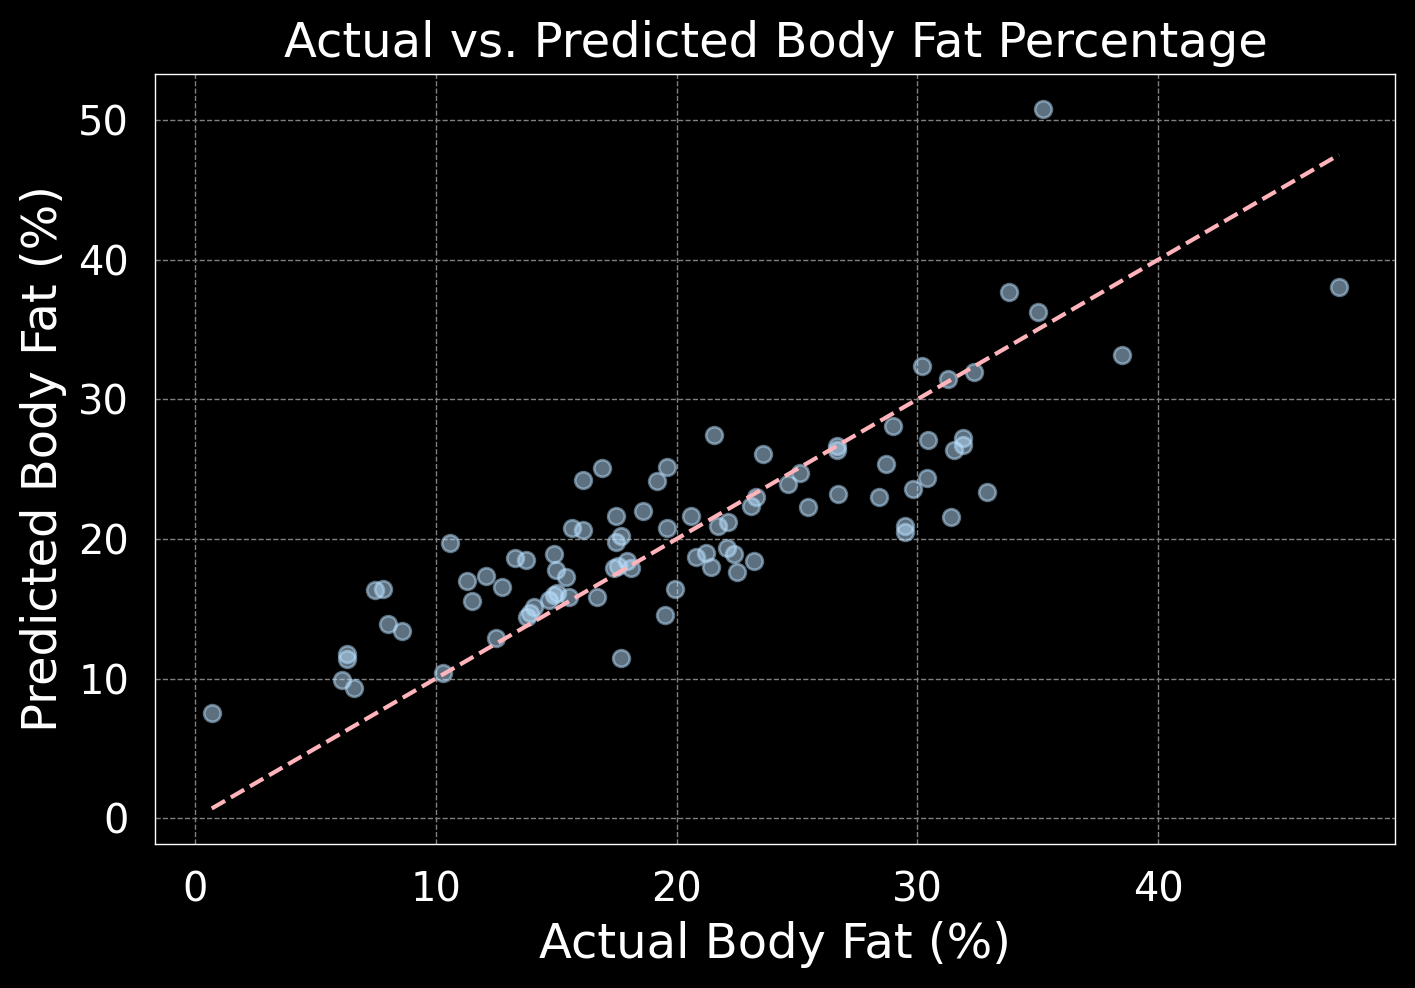

In [17]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title("Actual vs. Predicted Body Fat Percentage")
plt.xlabel("Actual Body Fat (%)")
plt.ylabel("Predicted Body Fat (%)")

plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color=COLORS[1],
    linestyle="--",
)
plt.show()

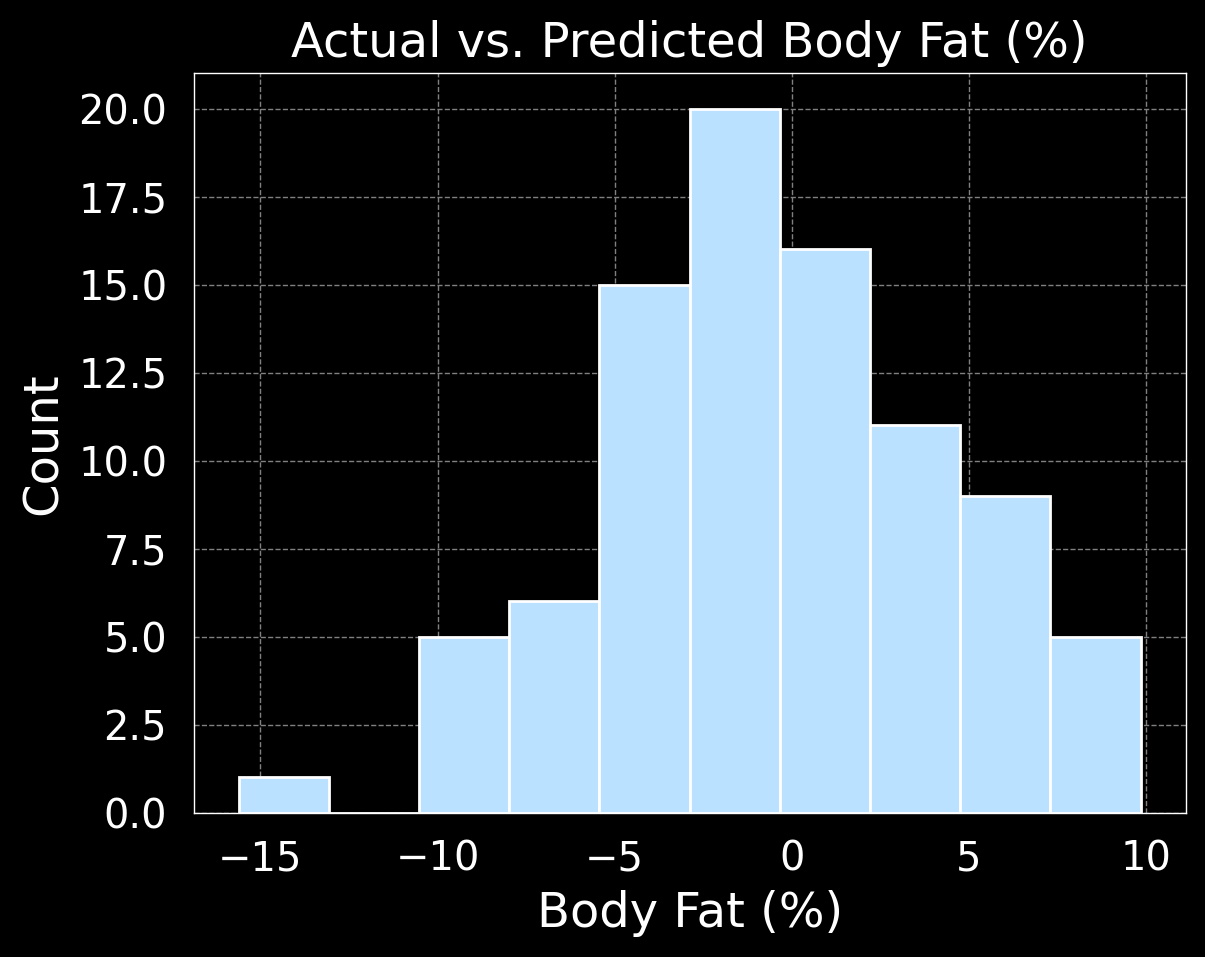

In [18]:
pred_difference = y_test - y_pred
plt.hist(pred_difference)
plt.title("Actual vs. Predicted Body Fat (%)")
plt.xlabel("Body Fat (%)")
plt.ylabel("Count")
plt.show();

## Save the Pipeline

In [19]:
model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

In [20]:
model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'weight', 'height',
                                                   'neck', 'chest', 'abdomen',
                                                   'hip', 'thigh', 'knee',
                                                   'ankle', 'biceps', 'forearm',
                                                   'wrist', 'BMI', 'BAI',
                                                   'WHR']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex'])])),
                ('regressor', LinearRegression())])

In [21]:
model_path = Path("model.pkl")

with model_path.open("wb") as f:
    pickle.dump(model, f)

In [22]:
with model_path.open("rb") as f:
    model = pickle.load(f)

In [23]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'weight', 'height',
                                                   'neck', 'chest', 'abdomen',
                                                   'hip', 'thigh', 'knee',
                                                   'ankle', 'biceps', 'forearm',
                                                   'wrist', 'BMI', 'BAI',
                                                   'WHR']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex'])])),
                ('regressor', LinearRegression())])

In [24]:
pred = model.predict(X)
rmse = mean_squared_error(y, pred, squared=False)
rmse

3.9738026913353783